In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd
import inspect
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display
import time

In [13]:
def E0(layers):
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3

In [75]:
def create_graph(layers,seed):
    np.random.seed(seed)
    G = ntx.Graph()
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
    return G
print(inspect.getdoc(create_graph))

None


In [3]:
def E0(x):
    m1=[]
    for j in np.arange(0,x*x,x):
        m1.append([(i+j,i+1+j) for i in range(x-1)])
    return np.array(m1).reshape(-1,2) 

def E1(x):
    m1=[]
    for j in np.arange(0,x*x-x,1):
        m1.append((j,x+j))
    return np.array(m1).reshape(-1,2) 
def graph(x):
#    node_mapping={}
#    node_count = 0
    G = ntx.Graph()    
    e0 = E0(x)
    e1= E1(x)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
#    for node in G.nodes:
        
    return G

In [77]:
def create_3d_graph(layers, seed, depth):
    G_2d = graph(x)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect bottom layer even nodes to external_node_1
    for node in G_2d.nodes:
        if node % 2 == 0:
            G_3d.add_edge(node_mapping[(node, 0)], external_node_1)  # Bottom layer (z=0)

    # Connect top layer odd nodes to external_node_2
    for node in G_2d.nodes:
        if node % 2 == 1 and node < max(G_2d.nodes):
            G_3d.add_edge(node_mapping[(node, depth - 1)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2
print(inspect.getdoc(create_3d_graph))

None


In [ ]:
create_3d_graph(4, 1, 10)

In [ ]:
print(list(create_3d_graph(4,1,2).neighbors(65)))

In [ ]:
# Extract node positions for plotting
#pos_3d = {node: (node[0], node[1]) for node in create_3d_graph(4, 1, 2).edges}  
#pos_3d

In [5]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

In [7]:
#create_graph(layers,seed)
def matrix_interactions(seed,R, std,w):
    grid = graph(50)  
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    np.random.seed(seed)
#    h= int(0.00001 * num_edges)

#    cap_values = np.abs(generate_random_values(1, 0, seed, num_edges))
    rns = np.abs(generate_random_values(R, std, seed, num_edges))
    rj = np.abs(generate_random_values(1, std, seed, num_edges))
#    np.random.shuffle(cap_values)
    np.random.shuffle(rns)
    np.random.shuffle(rj)
    interactions = 1 / (rns+rj/(1+(w*rj*1)**2))
    #print(cap_values)

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)


    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < 100:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())
    

    return MI

In [9]:
imp = pd.read_csv(f'/home/shardul/impedance_exp/nyquist/Impedance NbMoSe2.csv',delimiter=',')
new_imp = pd.DataFrame()
new_imp["freq"] = pd.to_numeric(imp.dropna(subset = 'ang freq',inplace = False)['ang freq'],errors='coerce').dropna()
freq=np.array(new_imp['freq'])

In [37]:
pd5 = pd.DataFrame()

In [39]:
progress = IntProgress(min=0, max=100, value=0)
label = HTML()
box = VBox(children=[label, progress])
display(box)

In [ ]:
def R(seed,R1,std,w):
    MI = matrix_interactions(seed,R1,std,w)
    #print(w)
    return MI[625, 625] + MI[1875,1875] - MI[625,1875] - MI[625,1875] 

In [ ]:
for r_mean in np.arange(1,10,2):
    print(r_mean)
    for rr in np.arange(1,r_mean,0.2):
        progress.value = rr+0.2
        label.value= f"Current resistance: {rr}"
        pd4[f'{rr}_mean_std_{r_mean}']= [np.mean([R(seed,r_mean,rr,w) for seed in range(5)]) for w in np.linspace(0,2,50)]
        #plt.plot(np.linspace(0,10,50),pd4[f'{rr}_std'],label=f'{rr}')
#plt.legend()
#plt.show()

1
3
0.0
0.0
0.0
0.0
0.0
0.04081632653061224
0.04081632653061224
0.04081632653061224
0.04081632653061224
0.04081632653061224
0.08163265306122448
0.08163265306122448
0.08163265306122448
0.08163265306122448
0.08163265306122448
0.12244897959183673
0.12244897959183673
0.12244897959183673
0.12244897959183673
0.12244897959183673
0.16326530612244897
0.16326530612244897
0.16326530612244897
0.16326530612244897
0.16326530612244897
0.2040816326530612
0.2040816326530612
0.2040816326530612
0.2040816326530612
0.2040816326530612
0.24489795918367346
0.24489795918367346
0.24489795918367346
0.24489795918367346
0.24489795918367346
0.2857142857142857
0.2857142857142857
0.2857142857142857
0.2857142857142857
0.2857142857142857
0.32653061224489793
0.32653061224489793
0.32653061224489793
0.32653061224489793
0.32653061224489793
0.36734693877551017
0.36734693877551017
0.36734693877551017
0.36734693877551017
0.36734693877551017
0.4081632653061224
0.4081632653061224
0.4081632653061224
0.4081632653061224
0.40816326

In [15]:
from concurrent.futures import ProcessPoolExecutor

In [19]:

def compute_R_values(seed, R1, std, w_values):
    MI_values = [matrix_interactions(seed, R1, std, w) for w in w_values]
    R_values = np.array([MI[0, 0] + MI[2499, 2499] - MI[0, 2499] - MI[2499, 0] for MI in MI_values])
    return R_values

def parallel_compute_R(R1, std, w_values, num_seeds):
    # Function to run parallel computation across multiple seeds
    with ProcessPoolExecutor() as executor:
        # Submit tasks for each seed to the executor
        futures = [executor.submit(compute_R_values, seed, R1, std, w_values) for seed in range(num_seeds)]
        
        # Collect results as they complete
        results = [future.result() for future in futures]

    # Average the results across all seeds
    mean_R_values = np.mean(results, axis=0)
    return mean_R_values

# Precompute and cache the w values
w_values = np.linspace(0, 10, 50)

# Initialize the DataFrame to store results
pd4 = pd.DataFrame()

# Number of seeds to use
num_seeds = 5

# Loop over standard deviation values
for rr in np.arange(1, 10, 2):
    print(rr)
    
    # Perform parallel computation for each standard deviation value
    R_results = parallel_compute_R(10, rr, w_values, num_seeds)
    
    # Store the mean results in the DataFrame
    pd4[f'{rr}_std'] = R_results
    
    # Plot the results
    plt.plot(w_values, pd4[f'{rr}_std'], label=f'{rr}')

plt.legend()
plt.show()

1


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [43]:
imp = pd.read_csv(f'/home/shardul/impedance_exp/nyquist/Impedance NbMoSe2.csv',delimiter=',')

In [47]:
new_imp["freq"] = pd.to_numeric(imp.dropna(subset = 'ang freq',inplace = False)['ang freq'],errors='coerce').dropna()
freq=np.array(new_imp['freq'])

In [65]:
for R1 in np.arange(0.1,2,0.1):
    print(R1)
    joop=[np.mean([R(seed,100,R1,0.5,w) for seed in range(100)]) for w in freq]
    df1[f'Z_{R}'] = joop
    

0.1
0.2
0.30000000000000004


KeyboardInterrupt: 

In [168]:
# depth decides # no of flakes in the box
def create_3d_graph_ip(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {} 
    
    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect side layer even nodes to external_node_1
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 0:
                G_3d.add_edge(node_mapping[(node, x)], external_node_1)  # side l

    # Connect side layer odd nodes to external_node_2
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 7 :
                G_3d.add_edge(node_mapping[(node, x)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [169]:
def matrix_interactions_ip(seed, depth, std):

    grid,a,b = create_3d_graph_ip(4, seed, depth)  # Assuming this function exists
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    
    np.random.seed(seed)
    
    h= int(0.00001*num_edges)

    
    cap_values = np.abs(1 * np.concatenate((generate_random_values(100, std, seed, num_edges-h),generate_random_values(0.001, 0, seed, h))))
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)

    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < a:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, a,b


In [131]:
def R_ip(seed,depth,h):
    MI,a,b = matrix_interactions_ip(seed,depth,h)
    return MI[a, a] + MI[b, b] - MI[a,b] - MI[b, a] 

In [173]:
for depth in np.arange(10,100,10):
    print(depth)
    joop=[np.mean([R_ip(seed,depth,std) for seed in range(50)]) for std in np.arange(0,70,5)]
    df1[f"{depth}_rip"] = joop

10
20
30
40
50
60
70
80
90


In [174]:
df1.head()

,10_roop,20_roop,30_roop,40_roop,50_roop,60_roop,70_roop,80_roop,90_roop,10_rip,20_rip,30_rip,40_rip,50_rip,60_rip,70_rip,80_rip,90_rip
0,390.560888,465.703266,466.881454,466.903507,466.903922,466.903929,466.903930,466.903930,466.903930,10.505805,5.176931,3.434713,2.569864,2.052940,1.709148,1.463985,1.280331,1.137620
1,390.484357,465.646877,466.777284,466.845801,466.820980,466.817493,466.864104,466.814079,466.795482,10.485646,5.168383,3.429059,2.565623,2.049829,1.706603,1.461428,1.278190,1.135936
2,390.248948,465.480309,466.561841,466.675203,466.628625,466.622492,466.710138,466.615760,466.578476,10.429460,5.141683,3.411512,2.552367,2.039460,1.698038,1.453693,1.271523,1.130235
3,389.847239,465.198548,466.229368,466.385576,466.321252,466.314074,466.435624,466.303103,466.247454,10.335156,5.095730,3.381384,2.529565,2.021383,1.683099,1.440463,1.260049,1.120278
4,389.264707,464.791958,465.769219,465.965750,465.888328,465.882341,466.028599,465.864835,465.791819,10.198661,5.028328,3.337296,2.496176,1.994710,1.661087,1.421120,1.243214,1.105592


Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hostpots = 10%')

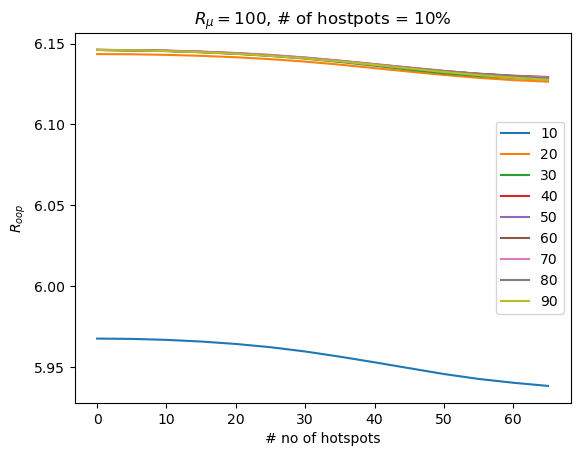

In [183]:
for x in np.arange(10,100,10):
    plt.plot(np.arange(0,70,5),np.log(df1[f'{x}_roop']),label=f'{x}')
plt.xlabel('# no of hotspots')
plt.ylabel(r'$R_{oop}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hostpots = 10%')

Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hotspots = 10%')

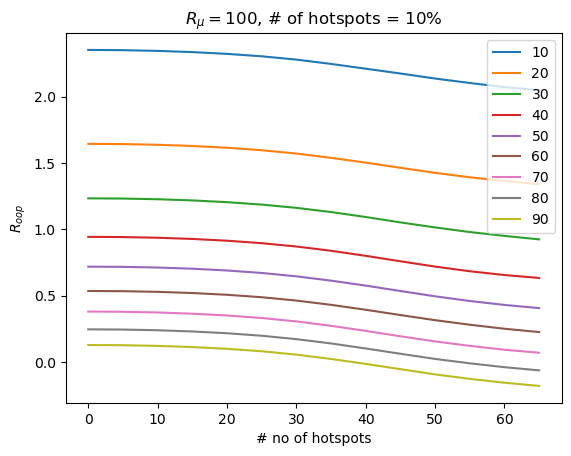

In [185]:
for x in np.arange(10,100,10):
    plt.plot(np.arange(0,70,5),np.log(df1[f'{x}_rip']),label=f'{x}')
plt.xlabel('# no of hotspots')
plt.ylabel(r'$R_{oop}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hotspots = 10%')

Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hotspots = 10%')

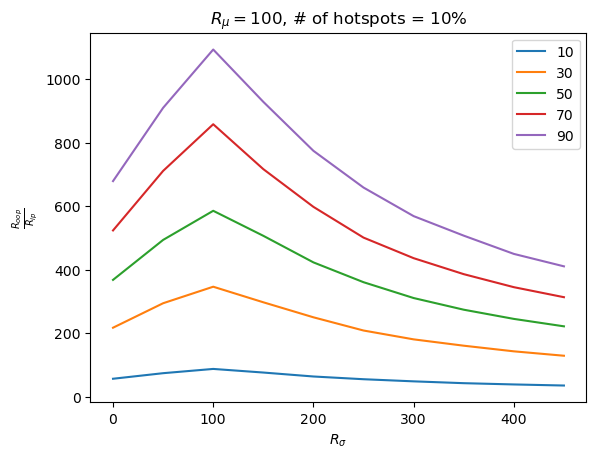

In [193]:
for x in np.arange(10,100,20):
    plt.plot(np.arange(0,500,50),df[f'{x}_roop']/df[f'{x}_rip'],label=f'{x}')
plt.xlabel(r'$R_{\sigma}$')
plt.ylabel(r'$\frac{R_{oop}}{R_{ip}}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hotspots = 10%')

In [ ]:
df = pd.DataFrame()
df["Rop"] = joop
df["Rip"]= jip

In [ ]:
df["ratio"] = 1*(df["Rop"]/df["Rip"])

In [ ]:
df.to_csv('resistance_brick.csv')

In [ ]:
plt.plot(np.arange(10,100,1),df["Rop"],label=r'$R_{op}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{op}$',fontsize=15)
plt.title(r'$R_{\mu} = 100$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


In [ ]:
plt.plot(np.arange(10,100,1),df["Rip"],label=r'$R_{ip}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{ip}$',fontsize=15)
plt.title(r'$R_{\mu} = 100$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)

In [ ]:
plt.plot(np.arange(10, 100,1), df["ratio"], label=r'$\frac{\sigma_{op}}{\sigma_{ip}}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$\frac{R_{op}}{R_{ip}}$',fontsize=15)
plt.grid(True)

In [ ]:
generate_random_values(100, 1, 1, 10)

In [ ]:
np.abs(1 * np.concatenate((generate_random_values(100, 10, 0, 10-5),generate_random_values(0.001, 0, 0,5))))